In [1]:
import pandas as pd
import numpy as np
import itertools
import random
import math
from collections import defaultdict
from collections import Counter
import itertools
from matplotlib import pyplot as plt

# Reading data

In [2]:
alunos = pd.read_csv('alunos.csv', sep=';')
alunos.head()

,Data,Idade,Doenca
0,21/9/2019,16,sarampo
1,19/8/2006,18,meningite
2,15/1/2011,16,meningite
3,13/2/2009,17,catapora
4,19/6/2006,18,meningite


In [3]:
def pre_processing(path):
    students = pd.read_csv(path, sep=';')
    split_data = students.copy()
    complemento = students['Data'].str.split('/', expand=True)
    split_data['Dia'], split_data['Mes'], split_data['Ano'] = complemento[0], complemento[1], complemento[2]
    decades = [year[:-1]+'0s' for year in split_data['Ano']]
    split_data['Decada'] = decades
    
    split_data['FaixaEtaria'] = [None]*len(split_data)
    bins = [int(split_data['Idade'].min())-1, int(split_data['Idade'].min())+2, int(split_data['Idade'].max())+1]
    labels = [str(bins[i-1])+'-'+str(bins[i]-1) for i in range(1, len(bins))]
    split_data['FaixaEtaria'] = pd.cut(split_data['Idade'], bins=bins, labels=labels)
    
    split_data['RangeMaximo'] = [str(split_data['Idade'].min())+'-'+str(split_data['Idade'].max())]*len(split_data)
    
    split_data = split_data[['Dia', 'Mes', 'Ano', 'Decada', 'Idade', 'FaixaEtaria', 'RangeMaximo', 'Doenca']]
    
    return students, split_data

### Separating data to generalize it when necessary

In [4]:
original_data, split_data = pre_processing('alunos.csv')

In [5]:
split_data

,Dia,Mes,Ano,Decada,Idade,FaixaEtaria,RangeMaximo,Doenca
0,21,9,2019,2010s,16,15-17,16-20,sarampo
1,19,8,2006,2000s,18,15-17,16-20,meningite
2,15,1,2011,2010s,16,15-17,16-20,meningite
3,13,2,2009,2000s,17,15-17,16-20,catapora
4,19,6,2006,2000s,18,15-17,16-20,meningite
...,...,...,...,...,...,...,...,...
295,8,10,2017,2010s,17,15-17,16-20,sarampo
296,21,9,2005,2000s,19,18-20,16-20,catapora
297,29,5,2005,2000s,16,15-17,16-20,sarampo
298,19,1,2007,2000s,19,18-20,16-20,sarampo


In [6]:
students = split_data[['Dia','Mes','Ano','Idade','Doenca']]
students

,Dia,Mes,Ano,Idade,Doenca
0,21,9,2019,16,sarampo
1,19,8,2006,18,meningite
2,15,1,2011,16,meningite
3,13,2,2009,17,catapora
4,19,6,2006,18,meningite
...,...,...,...,...,...
295,8,10,2017,17,sarampo
296,21,9,2005,19,catapora
297,29,5,2005,16,sarampo
298,19,1,2007,19,sarampo


In [7]:
def initial_clusters(dataset, k):   
    def priority(dataset):
        generalization_order = [list(dataset.columns[i:-1]) for i in range(len(dataset.columns)-1)]
        generalization_order = [dataset.groupby(generalization_order[i]).groups for i in range(len(generalization_order))]

        return generalization_order
    
    clusters = defaultdict(list)
    clustered = set()
    generalization_order = priority(dataset)

    for i in range(len(generalization_order)):
        for key, value in zip(generalization_order[i].keys(), generalization_order[i].values()):
            if len(value) >= k and len(clustered.intersection(value)) == 0:
                # se o grupo do groupby é maior ou igual a k e nenhum dos valores já estiver agrupado
                clusters[key] = list(itertools.chain(value))
                clustered = clustered.union(clusters[key])
                
    return clusters, clustered

In [8]:
clusters, clustered = initial_clusters(students, 2)
clusters

defaultdict(list,
            {('5', '4', '2011', 18): [111, 212],
             ('1', '2011', 16): [2, 193],
             ('1', '2014', 20): [109, 275],
             ('1', '2015', 19): [178, 214],
             ('10', '2006', 19): [40, 209],
             ('10', '2012', 19): [175, 242, 299],
             ('11', '2007', 19): [15, 161],
             ('11', '2017', 16): [62, 119],
             ('11', '2019', 19): [21, 88],
             ('2', '2005', 18): [38, 55],
             ('2', '2006', 16): [29, 136],
             ('2', '2009', 17): [3, 248],
             ('2', '2012', 19): [60, 118],
             ('2', '2015', 20): [87, 102],
             ('3', '2007', 17): [154, 231],
             ('3', '2007', 19): [47, 155],
             ('3', '2013', 18): [148, 282],
             ('3', '2015', 17): [112, 254],
             ('3', '2017', 18): [100, 270],
             ('3', '2018', 16): [9, 96],
             ('4', '2005', 18): [67, 217],
             ('4', '2009', 20): [77, 210],
             ('4', 

In [9]:
def generalization_trees():
    date_lvl = {
        ('Dia', 'Mes', 'Ano'): 1,
        ('Mes', 'Ano'): 2,
        ('Ano'): 3,
        ('Decada'): 4
    }

    age_lvl = {
        ('Idade'): 1,
        ('FaixaEtaria'): 2,
        ('RangeMaximo'): 3
    }

    return date_lvl, age_lvl
def sort_priority(all_combinations):
    gen_trees = generalization_trees()
    #periods_date = list(gen_trees[0].keys())
    #periods_age = list(gen_trees[1].keys())

    #all_combinations = list(itertools.product(periods_date, periods_age))
    #print(all_combinations)
    order = []
    for i in all_combinations:
        order.append(gen_trees[0][i[0]]+gen_trees[1][i[1]])

    #sorted_all_combinations = [x for _, x in sorted_lists]
    #result_list = [i for _,i in sorted(zip(order,all_combinations))]

    A = np.array(all_combinations, dtype=object)
    B = np.array(order)
    inds = B.argsort()
    sorted_all_combinations = A[inds]
    sorted_all_combinations = sorted_all_combinations.tolist()
    #print("´´´´", sorted_all_combinations)
    
    return sorted_all_combinations

def priority_level(dataset):
    gen_trees = generalization_trees()
    periods_date = list(gen_trees[0].keys())
    periods_age = list(gen_trees[1].keys())

    all_combinations = list(itertools.product(periods_date, periods_age))
    all_combinations = sort_priority(all_combinations)
    all_combinations = [list(itertools.chain.from_iterable([[i] if(type(i) == str) else list(i) for i in list_i ])) \
                        for list_i in all_combinations] 
    
    #print(all_combinations)
    all_combinations = [i for i in all_combinations if('FaixaEtaria' in i or 'RangeMaximo' in i or 'Decada' in i)]
    #print(all_combinations) 
    all_groups = [dataset.groupby(all_combinations[i]).groups for i in range(len(all_combinations))] # pra que era isso msm?
    #print(all_groups)
    return all_groups


def calc_distance(x, y, attributes):
    D = 0
    for attr in attributes:
        if(x[attr] != y[attr]):
            D += 1
        #print(attr, ': ', D, ' - ', x[attr], ' ?= ', y[attr])
            
    return D


def cluster_by_priority(dataset, clusters, clustered, k):
    not_clustered = list(set(dataset.index) - set(clustered))
    not_clustered_df = dataset.loc[not_clustered]
    groups = priority_level(not_clustered_df)

    merge_dict = {}
    for i in range(len(groups)):
        for key, value in zip(groups[i].keys(), groups[i].values()):
            if(len(value) > k):
                merge_dict[key] = list(value)
    print(merge_dict)

    for row_id in not_clustered:
        dist = math.inf
        cluster_dist = math.inf
        closest_cluster = ()
        for key in clusters.keys():
            cluster = clusters[key]

            cluster_dist = min( [ calc_distance(not_clustered_df.loc[row_id], split_data.loc[i], ['Dia', 'Mes', 'Ano', 'Decada', 'Idade', 'FaixaEtaria', 'RangeMaximo']) \
                                    for i in cluster[:2]] )

            if(cluster_dist < dist):
                dist = cluster_dist
                closest_cluster = key
        
        #print('mindist = ', dist, ' cluster -> ', closest_cluster)
        clusters[closest_cluster].append(row_id)
        clustered = clustered.union({row_id})
    
    #for i in range(len(groups)):
    #    for key, value in zip(groups[i].keys(), groups[i].values()):
    #        if len(value) > k and len(clustered.intersection(value)) == 0 : # and len(clustered.intersection(value)) == 0:
    #            # se o grupo do groupby é maior ou igual a k e nenhum dos valores já estiver agrupado
    #            clusters[key] = list(itertools.chain(list(set(value) - set(clustered))))
    #            clustered = clustered.union(clusters[key])
                
    return clusters, clustered, len(dataset) - len(clustered), list(set(dataset.index) - set(clustered))

#cluster_by_priority(split_data, clusters, clustered, 2)
#priority_level(split_data)

In [10]:
clusters, clustered, tuples_left, remaining_tuples,  = cluster_by_priority(split_data, clusters, clustered, 2)

{('1', '2018', '16-20'): [58, 187, 261], ('2005', '15-17'): [18, 116, 162, 253], ('2006', '15-17'): [4, 44, 105], ('2006', '18-20'): [31, 85, 151, 190, 198, 202, 215, 267], ('2007', '15-17'): [34, 81, 117, 225, 293], ('2007', '18-20'): [75, 204, 298], ('2008', '15-17'): [69, 172, 232, 281], ('2009', '15-17'): [24, 92, 176], ('2009', '18-20'): [11, 65, 93, 120, 142, 149, 153, 191, 263], ('2011', '15-17'): [25, 72, 137, 165, 186], ('2013', '15-17'): [7, 101, 230], ('2014', '15-17'): [107, 141, 226, 250, 255, 268, 286, 289], ('2015', '15-17'): [30, 51, 82, 86, 123, 211, 260], ('2015', '18-20'): [56, 106, 110, 221, 238, 265], ('2017', '15-17'): [63, 104, 174, 229, 237], ('2018', '15-17'): [68, 130, 187, 189, 200, 224, 261], ('2000s', 16): [24, 34, 44, 105, 176], ('2000s', 17): [81, 92, 253], ('2000s', 18): [4, 18, 69, 116, 117, 162, 172, 225, 232, 281, 293], ('2000s', 19): [11, 31, 65, 75, 151, 153, 191, 204, 240, 263, 267, 298], ('2000s', 20): [85, 93, 120, 142, 149, 190, 198, 202, 215], 

In [14]:
clusters


defaultdict(list,
            {('5', '4', '2011', 18): [111, 212, 25, 165, 186, 211, 224],
             ('1', '2011', 16): [2, 193, 24, 137],
             ('1', '2014', 20): [109, 275, 5, 58, 182, 238, 265],
             ('1', '2015', 19): [178, 214, 28, 56, 110, 221],
             ('10', '2006', 19): [40, 209, 31, 44, 151, 153, 198, 240, 267],
             ('10', '2012', 19): [175, 242, 299],
             ('11', '2007', 19): [15, 161, 75, 204, 298],
             ('11', '2017', 16): [62, 119, 63, 104, 174, 229, 237],
             ('11', '2019', 19): [21, 88],
             ('2', '2005', 18): [38, 55, 18, 116, 162, 232],
             ('2', '2006', 16): [29, 136, 105],
             ('2', '2009', 17): [3, 248, 92],
             ('2', '2012', 19): [60, 118],
             ('2', '2015', 20): [87, 102, 106],
             ('3', '2007', 17): [154, 231, 81],
             ('3', '2007', 19): [47, 155],
             ('3', '2013', 18): [148, 282, 101, 189, 230],
             ('3', '2015', 17): [112, 

In [12]:
tuples_left

0

In [13]:
len(clustered)

300

In [14]:
split_data.loc[[17, 146, 140, 127]]

,Dia,Mes,Ano,Decada,Idade,FaixaEtaria,RangeMaximo,Doenca
17,9,7,2010,2010,19,18-20,16-20,meningite
146,23,11,2007,2000,20,18-20,16-20,catapora
140,7,6,2007,2000,20,18-20,16-20,meningite
127,14,11,2010,2010,19,18-20,16-20,gripe


In [16]:
list(range(5))

[0, 1, 2, 3, 4]

# k-anonimato

In [15]:
def k_anonymity(dataset, clusters):
    k_anonymized = pd.DataFrame([[None]*3]*len(dataset), columns=dataset.columns)
   
    for key, value in zip(clusters.keys(), clusters.values()):
        if not isinstance(key, list) and isinstance(key, str):
            if '-' not in key:
                k_anonymized.loc[value] = [[key, '{}-{}'.format(dataset['Idade'].min(), dataset['Idade'].max()), key]+[dataset[dataset.columns[-1]].loc[v]] for v in value]
            else:
                k_anonymized.loc[value] = [['*', key]+[dataset[dataset.columns[-1]].loc[v]] for v in value]

        if not isinstance(key, list) and isinstance(key, int):
            k_anonymized.loc[value] = [['*', key]+[dataset[dataset.columns[-1]].loc[v]] for v in value]

        elif all(map(lambda x: isinstance(x, str), key)):
            k_anonymized.loc[value] = [[k for k in key]+[dataset[dataset.columns[-1]].loc[v]] for v in value]

        else:
            to_fill = [key[0]]
            for i in range(1, len(key)):
                if type(key[i]) == str:
                    to_fill[0] = to_fill[0] + str('/'+key[i])
                else:
                    to_fill.append(key[i])
            k_anonymized.loc[value] = [to_fill+[dataset[dataset.columns[-1]].loc[v]] for v in value]

    return k_anonymized

In [16]:
def plot_histogram(clusters):
    lengths = []
    for cluster in clusters.values():
        lengths.append(len(cluster))

    counter = dict(sorted(Counter(lengths).items()))
    keys_str = [str(key) for key in counter.keys()]
    plt.bar(keys_str, counter.values())
    
    return plt.show()

# Chamadas de funções

In [22]:
clusters, clustered = initial_clusters(split_data, 20)
all_clusters = cluster_by_priority(split_data, clusters, clustered, 20)

In [18]:
a = k_anonymity(alunos, clusters)
a

,Data,Idade,Doenca
0,2019,16,sarampo
1,8/2006,18,meningite
2,1/2011,16,meningite
3,2/2009,17,catapora
4,8/2006,18,meningite
...,...,...,...
295,2017,17,sarampo
296,2005,19,catapora
297,2005,16,sarampo
298,11/2007,19,sarampo


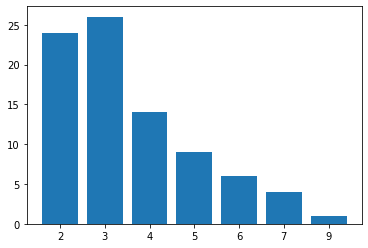

In [19]:
plot_histogram(clusters)